In [39]:
# coding: utf-8
import pandas as pd
import os
import re

In [40]:
base_path = '/home/jyliu/dataset/in-shop-Clothes-Retrieval/'

## 处理item，并转换为id

In [41]:
df = pd.read_csv(base_path + 'Anno/list_color_cloth.txt', sep=r'\s{2,}', skiprows=1, engine='python')#image_name, cloth_color

In [42]:
def parse_id(x):
    line = x.split('/')
    filename = line[-1]
    return line[-2] + '#' + filename.split('_')[0]
print(df.image_name[1])
print(parse_id(df.image_name[1]))

img/WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg
id_00000001#02


In [43]:
df = pd.read_csv(base_path + 'Anno/list_color_cloth.txt', sep=r'\s{2,}', skiprows=1, engine='python')
def parse_id(x):
    line = x.split('/')
    filename = line[-1]
    return line[-2] + '#' + filename.split('_')[0]  #  "id_00000001#02"
df['item_name'] = df.image_name.map(parse_id) # 每个image_name做一次parse_id， 变成上面的形式
item2id = {name: i for i, name in enumerate(df.item_name.drop_duplicates())} # 对应类别标签
df['item_id'] = df['item_name'].map(lambda x: item2id[x])
df.set_index('image_name', inplace=True)

## Landmark、衣服类型的处理

In [30]:
with open(base_path + 'Anno/list_landmarks_inshop.txt') as f:
    f.readline()
    f.readline()
    values = []
    for line in f:
        info = re.split('\s+', line)
    
        image_name = info[0].strip()
        clothes_type = int(info[1])
        variation_type = int(info[2])
        # 1 upper 6: ["left collar", "right collar", "left sleeve", "right sleeve", "left hem", "right hem"]
        # 2 lower 4: ["left waistline", "right waistline", "left hem", "right hem"]
        # 3 full 8: ["left collar", "right collar", "left sleeve", "right sleeve", "left waistline", "right waistline", "left hem", "right hem"].

        #In landmark visibility state, "0" represents visible, "1" represents invisible/occluded, "2" represents truncated/cut-off;
        landmark_postions = [(0, 0)] * 8
        landmark_visibilities = [1] * 8 
        landmark_in_pic = [1] * 8  # 1在图里（可见或被遮挡），0表示不在图里
        landmark_info = info[3:]
        if clothes_type == 1:  # 上身
            # 从上半身到全身的index映射
            convert = {0: 0, 1: 1, 2: 2, 3: 3, 4: 6, 5: 7}
        elif clothes_type == 2:
            convert = {0: 4, 1: 5, 2: 6, 3: 7}
        elif clothes_type == 3:
            convert = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}
        for i in convert:
            x = int(landmark_info[i * 3 + 1])#每三个一组：visible，x，y
            y = int(landmark_info[i * 3 + 2])
            vis = int(landmark_info[i * 3])
            if vis == 2:
                in_pic = 0  # 没有的
            elif vis == 1:
                in_pic = 1  # 有遮挡的
            else:
                in_pic = 1  # 1表示露出，和属性对齐
            if vis == 2:
                vis = 0  # 没有的
            elif vis == 1:
                vis = 0  # 有遮挡的
            else:
                vis = 1  # 1表示露出，和属性对齐
            landmark_postions[convert[i]] = (x, y)
            landmark_visibilities[convert[i]] = vis
            landmark_in_pic[convert[i]] = in_pic
        tmp = []
        for pair in landmark_postions:
            tmp.append(pair[0])
            tmp.append(pair[1])
        landmark_postions = tmp  # 展平,变成一个列表

        line_value = []
        line_value.extend([image_name, clothes_type, variation_type])
        line_value.extend(landmark_postions)
        line_value.extend(landmark_visibilities)
        line_value.extend(landmark_in_pic)
        values.append(line_value)

name = ['image_name', 'clothes_type', 'variation_type']
name.extend(['lm_lc_x', 'lm_lc_y', 'lm_rc_x', 'lm_rc_y',
             'lm_ls_x', 'lm_ls_y', 'lm_rs_x', 'lm_rs_y',
             'lm_lw_x', 'lm_lw_y', 'lm_rw_x', 'lm_rw_y',
             'lm_lh_x', 'lm_lh_y', 'lm_rh_x', 'lm_rh_y'])

name.extend([
    'lm_lc_vis', 'lm_rc_vis',
    'lm_ls_vis', 'lm_rs_vis',
    'lm_lw_vis', 'lm_rw_vis',
    'lm_lh_vis', 'lm_rh_vis',
])

name.extend([
    'lm_lc_in_pic', 'lm_rc_in_pic',
    'lm_ls_in_pic', 'lm_rs_in_pic',
    'lm_lw_in_pic', 'lm_rw_in_pic',
    'lm_lh_in_pic', 'lm_rh_in_pic',
])

landmarks = pd.DataFrame(values, columns=name)
landmarks.set_index('image_name', inplace=True)

In [31]:
landmarks

,clothes_type,variation_type,lm_lc_x,lm_lc_y,lm_rc_x,lm_rc_y,lm_ls_x,lm_ls_y,lm_rs_x,lm_rs_y,...,lm_lh_vis,lm_rh_vis,lm_lc_in_pic,lm_rc_in_pic,lm_ls_in_pic,lm_rs_in_pic,lm_lw_in_pic,lm_rw_in_pic,lm_lh_in_pic,lm_rh_in_pic
image_name,,,,,,,,,,,,,,,,,,,,,
img/WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg,1,1,117,67,144,65,73,219,183,210,...,1,0,1,1,1,1,1,1,1,1
img/WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg,1,2,128,64,131,65,122,215,129,218,...,0,0,1,1,1,1,1,1,1,1
img/WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg,1,3,143,60,115,59,187,222,74,223,...,1,1,1,1,1,1,1,1,1,1
img/WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg,1,4,121,39,136,39,94,120,150,121,...,0,1,1,1,1,1,1,1,1,1
img/WOMEN/Dresses/id_00000002/02_1_front.jpg,3,1,109,63,156,70,94,97,170,113,...,1,1,1,1,1,1,1,1,1,1
img/WOMEN/Dresses/id_00000002/02_2_side.jpg,3,2,127,59,145,61,121,97,160,94,...,0,1,1,1,1,1,1,1,1,1
img/WOMEN/Dresses/id_00000002/02_4_full.jpg,3,4,123,46,148,51,108,67,153,78,...,1,1,1,1,1,1,1,1,1,1
img/WOMEN/Dresses/id_00000002/02_7_additional.jpg,3,5,153,58,112,61,172,100,91,107,...,1,1,1,1,1,1,1,1,1,1
img/WOMEN/Skirts/id_00000003/02_1_front.jpg,2,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


## 合并信息

In [7]:
df = df.join(landmarks)
df.reset_index('image_name', inplace=True)

df.image_name = df.image_name.map(lambda x: base_path + x)

if os.path.exists('data') is False:
    os.makedirs('data')
df.to_csv('data/info.csv', index=False)

## 定义数据集

In [35]:
a = df.iloc[0]

In [36]:
a

clothes_color             Cream
item_name        id_00000001#02
item_id                       0
Name: img/WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg, dtype: object

In [38]:
a['item_id']

0

In [58]:
import torch
import torch.utils.data
import numpy as np
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, transform
import random
import skimage

class RandomFlip(object):

    def __call__(self, image):
        h, w = image.shape[:2]
        if np.random.rand() > 0.5:
            image = np.fliplr(image)

        return image


class CenterCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = int((h - new_h) / 2)
        left = int((w - new_w) / 2)

        image = image[top: top + new_h,
                      left: left + new_w]

        return image


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = random.randint(0, h - new_h)
        left = random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return image


class RandomRescale(object):

    def __init__(self, output_size_range):
        '''
        output_size_range指将短边缩放到的范围
        '''
        assert isinstance(output_size_range, tuple)
        self.lower_size = int(output_size_range[0])
        self.upper_size = int(output_size_range[1])

    def gen_output_size(self):
        return random.randint(self.lower_size, self.upper_size)

    def __call__(self, image):
        h, w = image.shape[:2]
        output_size = self.gen_output_size()
        if h > w:
            new_h, new_w = output_size * h / w, output_size
        else:
            new_h, new_w = output_size, output_size * w / h

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w), mode='constant')

        return img


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w), mode='constant')

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively

        return img



class DeepFashionInShopDataset(torch.utils.data.Dataset):

    def __init__(self, df, mode):
        '''
        mode:
            RANDOM：短边缩放到256->随机crop->随机flip
            CENTER：短边缩放到256->中心crop
        '''
        self.df = df
        
        self.rescale = Rescale(256)
        self.random_flip = RandomFlip()
        self.random_crop = RandomCrop((224, 224))
        self.center_crop = CenterCrop((224, 224))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def plot_sample(self, i):
        import matplotlib.pyplot as plt
        sample = self[i]
        image = sample['raw_image']
        plt.figure(dpi=72)
        plt.imshow(image)

    def __getitem__(self, i):
        sample = self.df.iloc[i]
        image = io.imread(sample['image_name'])
        if self.mode == 'RANDOM':
            image = self.rescale(image)
            image = self.random_crop(image)
            image = self.random_flip(image)
        elif self.mode == 'CENTER':
            image = self.rescale(image)
            image = self.center_crop(image)
        else:
            raise NotImplementedError

        # support special numpy type
        image = skimage.img_as_ubyte(image)
        image = image.copy()
        raw_image = image

        # convert to tensor and normalize
        image = self.to_tensor(image)
        image = self.normalize(image)
        image = image.float()

        label = sample['item_id']

        ret = {
            'image': image,
            'raw_image': raw_image,
            'label': label
        }
        return ret

In [62]:
dataset = DeepFashionInShopDataset(df, mode='RANDOM')

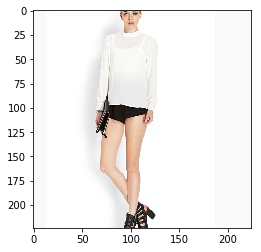

In [68]:
dataset.plot_sample(3)